In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data.csv")
df = df[df["RoleName"] != "Mentor"]

In [3]:
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(df[["content"]], df["OutcomeScore"])
x_train, x_test, y_train, y_test = train_test_split(x_resampled["content"], y_resampled, train_size=0.8, random_state=0)
_, x_test, _, y_test = train_test_split(df["content"], df["OutcomeScore"], train_size=0.8, random_state=0)
y_train.shape

(44719,)

In [4]:
vect = TfidfVectorizer(stop_words='english')
tfidf_matrix = vect.fit_transform(x_train)
tfidf = pd.DataFrame(tfidf_matrix.toarray(),columns=vect.get_feature_names())
print(tfidf)

        00  000  00pm   01   02   05   07  08pm   0s   10  ...   yu  yup  \
0      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
1      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
2      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
3      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
4      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
...    ...  ...   ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...   
44714  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
44715  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
44716  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
44717  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   
44718  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0   

       yupp  zach  zachary  zane  zelin  zero  zeroes  zeros  
0       0.0   0.0      0

In [5]:
lsvc = LinearSVC(penalty="l1", dual=False).fit(tfidf, y_train)

In [6]:
from time import time
threshold = 0.7

tic = time()
feature_names = np.array(tfidf.columns)
sfm = SelectFromModel(lsvc, threshold=threshold).fit(tfidf, y_train)
toc = time()
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")
print("Time taken: ", toc - tic, "seconds")

Features selected by SelectFromModel: ['00' '000' '00pm' ... 'zero' 'zeroes' 'zeros']
Time taken:  6.269592761993408 seconds


In [7]:
new_features = feature_names[sfm.get_support()]
new_features

array(['00', '000', '00pm', ..., 'zero', 'zeroes', 'zeros'], dtype=object)

In [8]:
x = tfidf[new_features]

In [9]:
x_train, x_test, y_train, t_test = train_test_split(x,y_train,random_state=0, train_size=0.8)

In [10]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=0)

In [11]:
pred = rf.predict(x_test)

In [12]:
f1_score(y_yest, pred, average="weighted")

0.7429284382670718

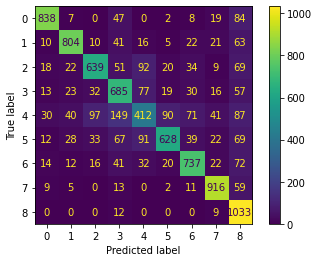

In [13]:
plot_confusion_matrix(rf, x_test, y_test);